## Out of date script used for fitting baseline classifier models. Simply kept for reference purposes.

In [1]:
# Import
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tifffile import imread
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, roc_auc_score
import sklearn.metrics as metrics
import os
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import product
from joblib import Parallel, delayed

In [2]:
# Load processed feature files
feature_dir = 'D:/AG/Features_2D_3D/'
features_df_dict = {}
for file in os.listdir(feature_dir):
    if file.endswith('.csv'):
        with open(feature_dir + file) as f:
            features_df_dict[file] = pd.read_csv(f)

# Here we assign test,train,validation sets
# Hoxb5 (first experiment) will be training data set.
# 0_55 is second experiment (test set, second largest, curated by DS).
# Other two are from third exp (the ones I curated) are for validation set (BOTH!).

print(features_df_dict.keys())

validation_images = {}
# Assigning the training set
train_2D = features_df_dict['features_2D_Hoxb5.csv']
train_3D = features_df_dict['features_3D_Hoxb5.csv']
# Assigning the test set
test_2D = features_df_dict['features_2D_0_55.csv']
test_3D = features_df_dict['features_3D_0_55.csv']

# Assigning the validation set
validation_2D = pd.concat([features_df_dict['features_2D_1000.csv'], features_df_dict['features_2D_950.csv']])
validation_3D = pd.concat([features_df_dict['features_3D_1000.csv'], features_df_dict['features_3D_950.csv']])


# Remove any columns containing NaN values, but print them first
print(train_2D.columns[train_2D.isna().any()].tolist())
print(test_2D.columns[test_2D.isna().any()].tolist())
print(validation_2D.columns[validation_2D.isna().any()].tolist())
print(train_3D.columns[train_3D.isna().any()].tolist())
print(test_3D.columns[test_3D.isna().any()].tolist())
print(validation_3D.columns[validation_3D.isna().any()].tolist())

train_2D = train_2D.dropna(axis=1)
train_3D = train_3D.dropna(axis=1)
test_2D = test_2D.dropna(axis=1)
test_3D = test_3D.dropna(axis=1)
validation_2D = validation_2D.dropna(axis=1)
validation_3D = validation_3D.dropna(axis=1)

# Check if all columns are the same, by comparing the columns of the first dataframe with the rest
print(train_2D.shape), print(test_2D.shape), print(validation_2D.shape)
print(train_3D.shape), print(test_3D.shape), print(validation_3D.shape)

# check what columns are different between the dataframes
diff_cols_2D = []
for i in [test_2D, validation_2D]:
    if train_2D.columns.difference(i.columns).any():
        diff_cols_2D.append(train_2D.columns.difference(i.columns))

diff_cols_2D = list(set([item for sublist in diff_cols_2D for item in sublist]))
print(f'2D:', diff_cols_2D)

diff_cols_3D = []
for i in [test_3D, validation_3D]:
    if train_3D.columns.difference(i.columns).any():
        diff_cols_3D.append(train_3D.columns.difference(i.columns))
diff_cols_3D = list(set([item for sublist in diff_cols_3D for item in sublist]))
print(f'3D:', diff_cols_3D)

# Check if all columns are the same, by comparing the columns of the first dataframe with the rest

# # Remove the different columns from the dataframes
for cols in diff_cols_2D:
    if cols in train_2D.columns:
        train_2D.drop(columns=[cols], inplace=True)
    if cols in test_2D.columns:
        test_2D.drop(columns=[cols], inplace=True)
    if cols in validation_2D.columns:
        validation_2D.drop(columns=[cols], inplace=True)

for cols3d in diff_cols_3D:
    if cols3d in train_3D.columns:
        train_3D.drop(columns=[cols3d], inplace=True)
    if cols3d in test_3D.columns:
        test_3D.drop(columns=[cols3d], inplace=True)
    if cols3d in validation_3D.columns:
        validation_3D.drop(columns=[cols3d], inplace=True)
# Print final shapes
print(train_2D.shape), print(test_2D.shape), print(validation_2D.shape)
print(train_3D.shape), print(test_3D.shape), print(validation_3D.shape)

print('Done')

dict_keys(['._features_2D_0_55.csv', '._features_2D_1000.csv', '._features_2D_950.csv', '._features_2D_Hoxb5.csv', '._features_3D_0_55.csv', '._features_3D_1000.csv', '._features_3D_950.csv', '._features_3D_Hoxb5.csv', 'features_2D_0_55.csv', 'features_2D_1000.csv', 'features_2D_950.csv', 'features_2D_Hoxb5.csv', 'features_3D_0_55.csv', 'features_3D_1000.csv', 'features_3D_950.csv', 'features_3D_Hoxb5.csv'])
['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0-0', 'moment

C:\Users\agreicius\AppData\Local\Temp\ipykernel_17388\1213991530.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3D.drop(columns=[cols3d], inplace=True)


In [3]:
# We will use the training set to train the model
# We will use the validation set to validate the model
# We will use the test set to test the model

scaler = StandardScaler()

def trim(x):
    x = x.loc[:, ~x.columns.str.contains('Identifier')] # These are not useful
    x = x.loc[:, ~x.columns.str.contains('mask_id')] # These are not useful
    return x

train_2D = trim(train_2D)
train_3D = trim(train_3D)
test_2D = trim(test_2D)
test_3D = trim(test_3D)
validation_2D = trim(validation_2D)
validation_3D = trim(validation_3D)

# 2D
train_X2 = train_2D.drop(columns=['label'])
train_X2 = scaler.fit_transform(train_X2)
train_y2 = train_2D['label']
test_X2 = test_2D.drop(columns=['label'])
test_X2 = scaler.transform(test_X2)
test_y2 = test_2D['label']
validation_X2 = validation_2D.drop(columns=['label'])
validation_X2 = scaler.transform(validation_X2)
validation_y2 = validation_2D['label']

# 3D
train_X3 = train_3D.drop(columns=['label'])
train_X3 = scaler.fit_transform(train_X3)
train_y3 = train_3D['label']
test_X3 = test_3D.drop(columns=['label'])
test_X3 = scaler.transform(test_X3)
test_y3 = test_3D['label']
validation_X3 = validation_3D.drop(columns=['label'])
validation_X3 = scaler.transform(validation_X3)
validation_y3 = validation_3D['label']

# # Show column names
# print(train_2D.columns)
# print(train_3D.columns)

# # Save column names to txt files
# with open(feature_dir + 'columns_2D.txt', 'w') as f:
#     for col in train_2D.columns:
#         f.write(col + '\n')

# with open( feature_dir + 'columns_3D.txt', 'w') as f:
#     for col in train_3D.columns:
#         f.write(col + '\n')

## Logistic Regression

In [4]:
# Create models
model2 = LogisticRegression(max_iter=1000, class_weight='balanced')
model3 = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train models
model2.fit(train_X2, train_y2)
model3.fit(train_X3, train_y3)

# Gather statistics of how each model performs
# 2D
train_pred2 = model2.predict(train_X2)
test_pred2 = model2.predict(test_X2)
val_pred2 = model2.predict(validation_X2)

# 3D
train_pred3 = model3.predict(train_X3)
test_pred3 = model3.predict(test_X3)
val_pred3 = model3.predict(validation_X3)

2D

Train accuracy: 1.0
Test accuracy: 0.9943639291465378
Validation accuracy: 0.9809437386569873
Confusion matrix [Test]:
[[1188    0]
 [   7   47]]
Confusion matrix [Validation]:
[[1031    3]
 [  18   50]]
ROC AUC [Train]: 1.0
ROC AUC [Test]: 0.9998908841501434
ROC AUC [Validation]: 0.9963093070884059
Precision [Test]: 1.0
Recall [Test]: 0.8703703703703703
Precision [Validation]: 0.9433962264150944
Recall [Validation]: 0.7352941176470589
##################################################
ROC [Test]
ROC [Validation]
Precision Recall [Test]
[0.04347826 1.         1.        ] [1.         0.87037037 0.        ]
##################################################
Accuracy [Test]: 0.9943639291465378
Precision [Test]: 1.0
Recall [Test]: 0.8703703703703703
F1 score [Test]: 0.9306930693069307
Confusion matrix [Test]:
[[1188    0]
 [   7   47]]


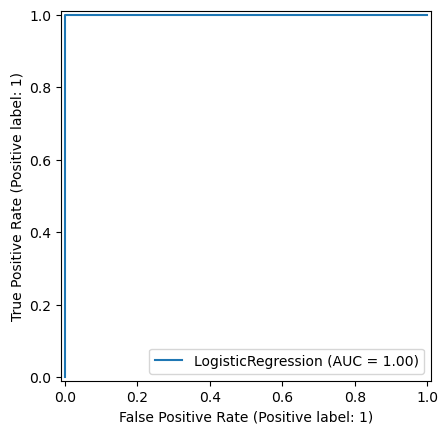

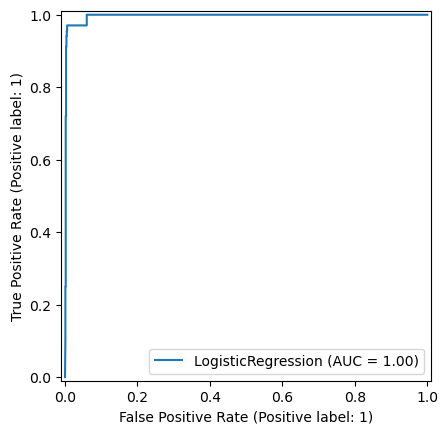

In [5]:

# Print statistics
print('2D\n')
print('Train accuracy:', accuracy_score(train_y2, train_pred2))
print('Test accuracy:', accuracy_score(test_y2, test_pred2))
print('Validation accuracy:', accuracy_score(validation_y2, val_pred2))
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y2, test_pred2))
print('Confusion matrix [Validation]:')
print(confusion_matrix(validation_y2, val_pred2))

print('ROC AUC [Train]:', roc_auc_score(train_y2, model2.predict_proba(train_X2)[:, 1]))
print('ROC AUC [Test]:', roc_auc_score(test_y2, model2.predict_proba(test_X2)[:, 1]))
print('ROC AUC [Validation]:', roc_auc_score(validation_y2, model2.predict_proba(validation_X2)[:, 1]))

print(f'Precision [Test]: {precision_score(test_y2, test_pred2)}')
print(f'Recall [Test]: {recall_score(test_y2, test_pred2)}')
print(f'Precision [Validation]: {precision_score(validation_y2, val_pred2)}')
print(f'Recall [Validation]: {recall_score(validation_y2, val_pred2)}')


print('#' * 50)

print('ROC [Test]')
RocCurveDisplay.from_estimator(model2, test_X2, test_y2)

print('ROC [Validation]')
RocCurveDisplay.from_estimator(model2, validation_X2, validation_y2)

precision, recall, thresholds = metrics.precision_recall_curve(test_y2, test_pred2)
print('Precision Recall [Test]')
print(precision, recall)


print('#' * 50)

# Accuracy
print('Accuracy [Test]:', accuracy_score(test_y2, test_pred2))
# Precision
print('Precision [Test]:', precision_score(test_y2, test_pred2))
# Recall
print('Recall [Test]:', recall_score(test_y2, test_pred2))
# F1 score
print('F1 score [Test]:', 2 * (precision_score(test_y2, test_pred2) * recall_score(test_y2, test_pred2)) / (precision_score(test_y2, test_pred2) + recall_score(test_y2, test_pred2)))
# Confusion matrix
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y2, test_pred2))


3D
Train accuracy: 1.0
Test accuracy: 0.9967793880837359
Validation accuracy: 0.985480943738657
Confusion matrix [Test]:
[[1188    0]
 [   4   50]]
Confusion matrix [Validation]:
[[1034    0]
 [  16   52]]
ROC AUC [Train]: 1.0
ROC AUC [Test]: 0.999984412021449
ROC AUC [Validation]: 0.9971270906815337
Precision [Test] = 1.0
Recall [Test] = 0.9259259259259259
Precision [Validation] = 1.0
Recall [Validation] = 0.7647058823529411
##################################################
ROC [Test]
ROC [Validation]
##################################################
Accuracy [Test]: 0.9967793880837359
Precision [Test]: 1.0
Recall [Test]: 0.9259259259259259
F1 score [Test]: 0.9615384615384615
Confusion matrix [Test]:
[[1188    0]
 [   4   50]]


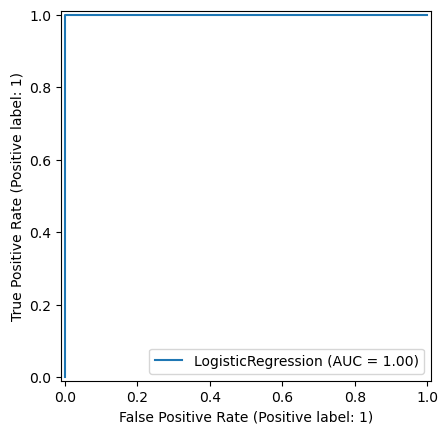

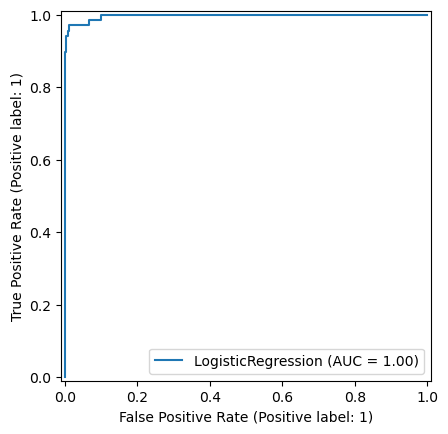

In [6]:
print('3D')

print('Train accuracy:', accuracy_score(train_y3, train_pred3))
print('Test accuracy:', accuracy_score(test_y3, test_pred3))
print('Validation accuracy:', accuracy_score(validation_y3, val_pred3))
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y3, test_pred3))
print('Confusion matrix [Validation]:')
print(confusion_matrix(validation_y3, val_pred3))

print('ROC AUC [Train]:', roc_auc_score(train_y3, model3.predict_proba(train_X3)[:, 1]))
print('ROC AUC [Test]:', roc_auc_score(test_y3, model3.predict_proba(test_X3)[:, 1]))
print('ROC AUC [Validation]:', roc_auc_score(validation_y3, model3.predict_proba(validation_X3)[:, 1]))

print(f'Precision [Test] = {precision_score(test_y3, test_pred3)}')
print(f'Recall [Test] = {recall_score(test_y3, test_pred3)}')

print(f'Precision [Validation] = {precision_score(validation_y3, val_pred3)}')
print(f'Recall [Validation] = {recall_score(validation_y3, val_pred3)}')

print('#' * 50)

print('ROC [Test]')
RocCurveDisplay.from_estimator(model3, test_X3, test_y3)

print('ROC [Validation]')
RocCurveDisplay.from_estimator(model3, validation_X3, validation_y3)

print('#' * 50)

# Accuracy
print('Accuracy [Test]:', accuracy_score(test_y3, test_pred3))
# Precision
print('Precision [Test]:', precision_score(test_y3, test_pred3))
# Recall
print('Recall [Test]:', recall_score(test_y3, test_pred3))
# F1 score
print('F1 score [Test]:', 2 * (precision_score(test_y3, test_pred3) * recall_score(test_y3, test_pred3)) / (precision_score(test_y3, test_pred3) + recall_score(test_y3, test_pred3)))
# Confusion matrix
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y3, test_pred3))

In [7]:
# Save models
# Logreg model dir:
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('models/logreg'):
    os.makedirs('models/logreg')

# Save models
with open('models/logreg/model2.pkl', 'wb') as f:
    pickle.dump(model2, f)
with open('models/logreg/model3.pkl', 'wb') as f:
    pickle.dump(model3, f)


## Random Forest

In [8]:
from numba import prange
import os
import pickle
from itertools import product
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix
from joblib import Parallel, delayed


In [9]:
param_grid = {
    'n_estimators': [10, 20, 50, 100], # Number of trees
    'criterion': ['gini', 'entropy', 'log_loss'],           # Split criterion
    'max_depth': [None, 10, 20, 30],                    # Max depth of the trees
    'min_samples_split': [2, 5, 10],                    # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 5],                    # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],                             # Whether to bootstrap samples when building trees
    'max_features': ['sqrt', 'log2', None]          # Number of features to consider when looking for the best split
}

In [10]:
# # Functions to train and evaluate models

def perform_training(param_grid, train_X2, train_y2, save_dir):
    # Generate all combinations of hyperparameters
    param_combinations = list(product(
        param_grid['n_estimators'],
        param_grid['criterion'],
        param_grid['max_depth'],
        param_grid['min_samples_split'],
        param_grid['min_samples_leaf'],
        param_grid['bootstrap'],
        param_grid['max_features'],
        ['balanced', None]  # Include class_weight manually
    ))

    # Iterate through 5 outer loops and train models
    for index in prange(5):
        for param_set in param_combinations:
            # Unpack the hyperparameters
            n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, bootstrap, max_features, class_weight = param_set
            
            # Initialize RandomForestClassifier with the current set of hyperparameters
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                criterion=criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                bootstrap=bootstrap,
                max_features=max_features,
                class_weight=class_weight
            )

            # Train the model
            rf.fit(train_X2, train_y2)

            # Save model using a unique name based on the combination
            model_name = f'rf_model_{index}_{n_estimators}_{criterion}_{max_depth}_{min_samples_split}_{min_samples_leaf}_{bootstrap}_{max_features}_{class_weight}.pkl'
            
            # saving the model (pkl)
            with open(save_dir + model_name, 'wb') as f:
                pickle.dump(rf, f)

def evaluate_models(model_dir, test_X2, test_y2, metric='roc_auc'):
    # Load all models, add them to a dictionary containing model names as keys, models as values
    models = {}
    for file in os.listdir(model_dir):
        if file.endswith('.pkl'):
            with open(model_dir + file, 'rb') as f:
                models[file] = pickle.load(f)

    # Evaluate all models

    # Initialize a dictionary to store the results
    results = {}
    # Results with hold nested dictionaries, where the outer key is the model name, inner key is the metric name
    # and the value is the metric value

    # We will evaluate the models using the test set, scoring them based on accuracy, precision, recall, and ROC AUC

    for model_name, model in models.items():
        # Predict using the test set
        test_pred = model.predict(test_X2)
        test_proba = model.predict_proba(test_X2)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(test_y2, test_pred)
        precision = precision_score(test_y2, test_pred)
        recall = recall_score(test_y2, test_pred)
        roc_auc = roc_auc_score(test_y2, model.predict_proba(test_X2)[:, 1])
        
        precision_curve, recall_curve, _ = precision_recall_curve(test_y2, test_proba)
        pr_auc = auc(recall_curve, precision_curve)

        f1_score_ = f1_score(test_y2, test_pred)

        confusion_matrix_ = confusion_matrix(test_y2, test_pred)
        TP = confusion_matrix_[0][0]
        FP = confusion_matrix_[0][1]
        FN = confusion_matrix_[1][0]
        TN = confusion_matrix_[1][1]
        confusion_matrix_ = f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}'

        # Store the results
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'f1_score': f1_score_,
            'confusion_matrix': confusion_matrix_,
            'hyperparameters': model.get_params()
        }
    
    # Order the models based on a metric of choice
    # We will use accuracy here
    results = dict(sorted(results.items(), key=lambda x: x[1][metric], reverse=True))
    
    # Save the results as a DataFrame (pandas)
    results_df = pd.DataFrame(results).T
    results_df.to_csv(model_dir + 'results.csv')

    return results_df

In [11]:
# Print and save the column names for train_X2 and train_X3

with open('columns_2D.txt', 'w') as f:
    f.write('\n'.join(train_2D.columns))

with open('columns_3D.txt', 'w') as f:
    f.write('\n'.join(train_3D.columns))

In [12]:
root_dir = 'D:/AG/models/rf/'
# Create if it doesnt exist
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

save_dir = root_dir + '2D/'
# Create if it doesnt exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
perform_training(param_grid, train_X2, train_y2, save_dir)
results_df_2D = evaluate_models(save_dir, test_X2, test_y2)
results_df_2D.to_csv('results_2D.csv')

# Using 3D data:
save_dir = root_dir + '3D/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
perform_training(param_grid, train_X3, train_y3, save_dir)
results_df_3D = evaluate_models(save_dir, test_X3, test_y3)
results_df_3D.to_csv('results_3D.csv')

print('fin')

fin


In [ ]:
# Evaluate on validation set
save_dir = root_dir + '2D/'
results_df_2D_val = evaluate_models(save_dir, validation_X2, validation_y2)
results_df_2D_val.to_csv('results_df_2D_val.csv')

save_dir = root_dir + '3D/'
results_df_3D_val = evaluate_models(save_dir, validation_X3, validation_y3)
results_df_3D_val.to_csv('results_df_3D_val.csv')